In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
DATA_PATH = "raw_data/2026-01-13/norm_indicators_BTCUSDT.csv"

TARGET_HORIZON = 1  #predict 1 period ahead
HIDDEN_SIZES=[128,64,32]
DROPOUT = 0.3

BATCH_SIZE = 64
EPOCHS = 100        
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

TEST_SIZE = 0.2
VAL_SIZE = 0.1

torch.manual_seed(42)
np.random.seed(42)

In [4]:
data = pd.read_csv(DATA_PATH, index_col = 0, parse_dates=True)
data.head()

,RSI_14,MACD_HIST,BB_POSITION,RET_1,RET_5,RET_15,PRICE_EMA21_DIST,ATR,RET_STD,VOL,VWAP_DIST,BODY_ATR,UPPER_WICK_ATR,LOWER_WICK_ATR
Timestamp,,,,,,,,,,,,,,
2021-02-03 08:00:00,0.241043,0.766984,0.743267,-0.377756,0.564120,1.085109,0.886003,-1.229179,0.436301,-0.324545,-0.385126,-0.304051,0.002224,0.424719
2021-02-03 12:00:00,0.331490,0.873115,0.951573,0.780077,0.431135,1.214219,1.406328,-1.195125,0.383037,-0.116924,0.772595,0.814413,0.062215,0.146598
2021-02-03 16:00:00,0.319736,0.813402,0.809429,-0.156423,0.548618,1.047009,1.168740,-1.349722,0.313561,-0.121001,0.440396,-0.058460,0.355312,0.139496
2021-02-03 20:00:00,0.397526,0.948178,0.958863,0.713091,0.456294,1.191007,1.598814,-1.327871,0.260244,-0.461940,1.474987,0.795460,0.041940,0.138442
2021-02-04 00:00:00,0.373060,0.891754,0.817041,-0.184935,0.446622,1.567032,1.296278,-1.335252,0.108684,-0.046030,-0.518228,-0.117380,0.645205,0.131033


In [5]:
data['TARGET_RET'] = data['RET_1'].shift(-TARGET_HORIZON)

In [6]:
data['TARGET_CLASS'] = (data['TARGET_RET'] > 0).astype(int)

In [7]:
clean_data = data.dropna(subset=['TARGET_RET']).copy()

In [8]:
print(f"Dataset size after removing NaN targets: {len(clean_data)}")
print(f"\nTarget distribution:")
print(clean_data['TARGET_CLASS'].value_counts())
print(f"\nClass balance: {clean_data['TARGET_CLASS'].value_counts(normalize=True)}")


Dataset size after removing NaN targets: 10829

Target distribution:
TARGET_CLASS
1    5455
0    5374
Name: count, dtype: int64

Class balance: TARGET_CLASS
1    0.50374
0    0.49626
Name: proportion, dtype: float64


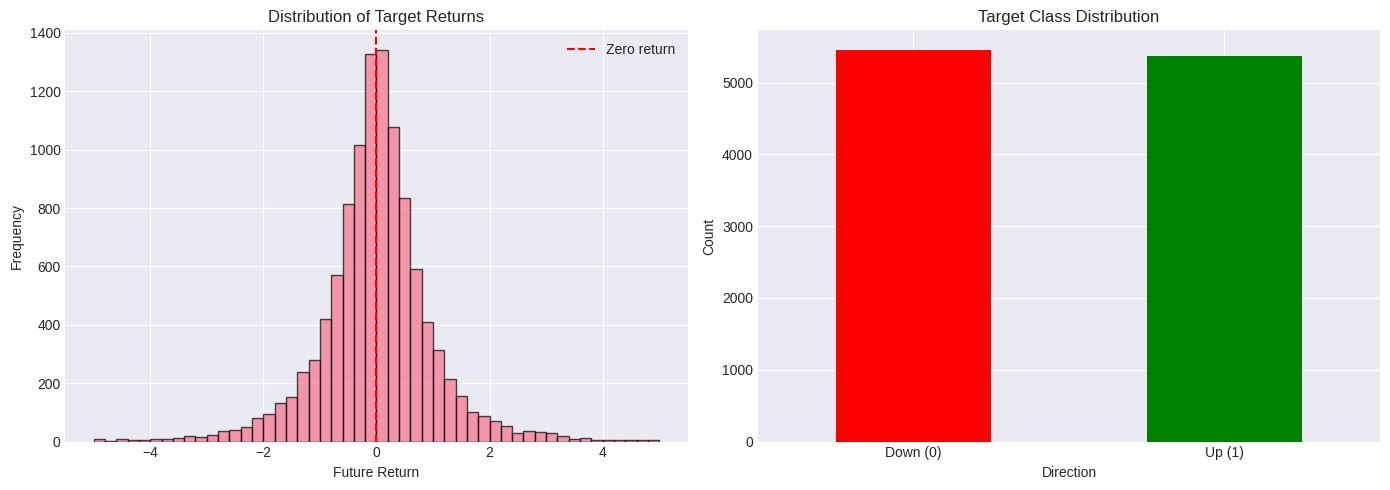

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of returns
axes[0].hist(clean_data['TARGET_RET'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Future Return')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target Returns')
axes[0].axvline(0, color='red', linestyle='--', label='Zero return')
axes[0].legend()

# Class distribution
clean_data['TARGET_CLASS'].value_counts().plot(kind='bar', ax=axes[1], color=['red', 'green'])
axes[1].set_xlabel('Direction')
axes[1].set_ylabel('Count')
axes[1].set_title('Target Class Distribution')
axes[1].set_xticklabels(['Down (0)', 'Up (1)'], rotation=0)

plt.tight_layout()
plt.show()

In [10]:
excluded_cols = ['TARGET_RET', 'TARGET_CLASS']
featured_cols = [col for col in clean_data.columns if col not in excluded_cols]

x = clean_data[featured_cols].values
y_regression = clean_data['TARGET_RET'].values
y_classification = clean_data['TARGET_CLASS'].values

In [11]:

print(f"\nFeature matrix shape: {x.shape}")
print(f"Target shape: {y_regression.shape}")

# Check for any NaN or inf values
print(f"\nData quality check:")
print(f"  NaN in X: {np.isnan(x).sum()}")
print(f"  Inf in X: {np.isinf(x).sum()}")
print(f"  NaN in y: {np.isnan(y_regression).sum()}")


Feature matrix shape: (10829, 14)
Target shape: (10829,)

Data quality check:
  NaN in X: 0
  Inf in X: 0
  NaN in y: 0


In [12]:
split_idx_1 = int(len(x) * (1 - TEST_SIZE))
x_temp, x_test = x[:split_idx_1], x[split_idx_1:]
y_temp, y_test = y_regression[:split_idx_1], y_regression[split_idx_1:]

split_idx_2 = int(len(x_temp) * (1 - (VAL_SIZE/(1 - TEST_SIZE))))
x_train, x_val = x_temp[:split_idx_2], x_temp[split_idx_2:]
y_train, y_val = y_temp[:split_idx_2], y_temp[split_idx_2:]

In [13]:

print(f"Dataset splits:")
print(f"  Train: {x_train.shape[0]} samples ({x_train.shape[0]/len(x)*100:.1f}%)")
print(f"  Val:   {x_val.shape[0]} samples ({x_val.shape[0]/len(x)*100:.1f}%)")
print(f"  Test:  {x_test.shape[0]} samples ({x_test.shape[0]/len(x)*100:.1f}%)")

Dataset splits:
  Train: 7580 samples (70.0%)
  Val:   1083 samples (10.0%)
  Test:  2166 samples (20.0%)


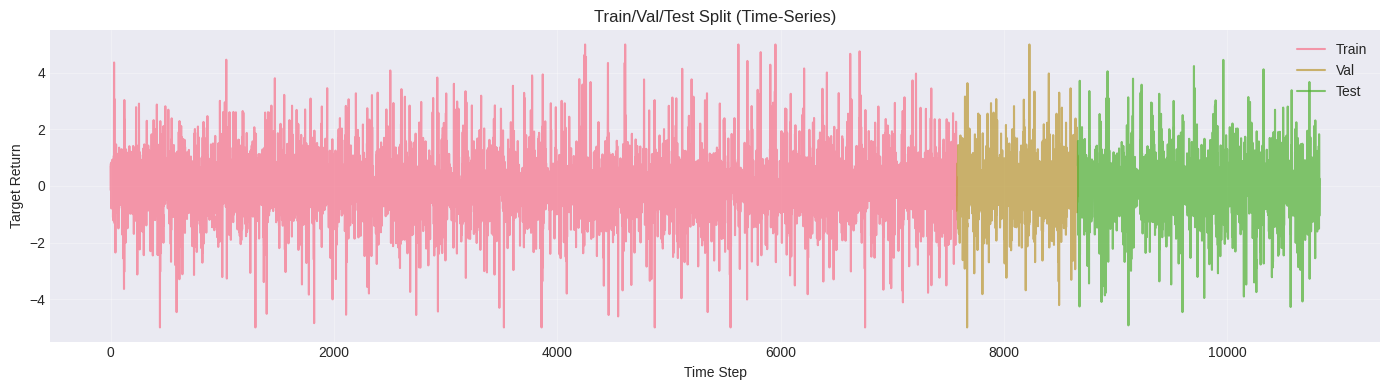

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))
time_index = np.arange(len(y_regression))
ax.plot(time_index[:len(y_train)], y_train, label='Train', alpha=0.7)
ax.plot(time_index[len(y_train):len(y_train)+len(y_val)], y_val, label='Val', alpha=0.7)
ax.plot(time_index[len(y_train)+len(y_val):], y_test, label='Test', alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Target Return')
ax.set_title('Train/Val/Test Split (Time-Series)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

DataLoaders created:
  Train batches: 119
  Val batches: 17
  Test batches: 34


In [16]:
class PricePredictionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128,64,32], dropout=0.3):
        super(PricePredictionNN, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
input_size = x_train.shape[1]

model = PricePredictionNN(input_size = input_size, 
                          hidden_sizes = HIDDEN_SIZES,
                          dropout=DROPOUT).to(device)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
PricePredictionNN(
  (network): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 12,737


In [18]:
def train_epochs(model, train_loader, optimiser, criterion, device):
    model.train()
    total_loss=0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        optimiser.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)

        loss.backward()
        optimiser.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [21]:
def val_epochs(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)

            total_loss += loss.item()

    return total_loss / len(val_loader)

In [ ]:
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 15
patience_counter = 0

print("Starting training.....\n")

for epoch in range(EPOCHS):
    train_loss = train_epochs(model=model, train_loader=train_loader, optimiser=optimiser, criterion=criterion, device=device)
    val_loss = val_epochs(model=model, val_loader=val_loader, criterion=criterion, device=device)

    if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
          torch.save(model.state_dict(), 'models/best_model.pth')
    
    else:
          patience_counter += 1
          if patience_counter >= patience:
                print(f"\nStopping early at epoch {epoch + 1}")
                break

model.load_state_dict(torch.load('models/best_model.pth'))
print(f"\n✓ Training complete! Best validation loss: {best_val_loss:.6f}")

Starting training.....

Epoch   1/100 | Train Loss: 1.141755 | Val Loss: 1.005226
Epoch  10/100 | Train Loss: 0.974615 | Val Loss: 1.010049
Epoch  20/100 | Train Loss: 0.949686 | Val Loss: 1.039395

Stopping early at epoch 20

✓ Training complete! Best validation loss: 0.997432


/tmp/ipykernel_5257/4159511739.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


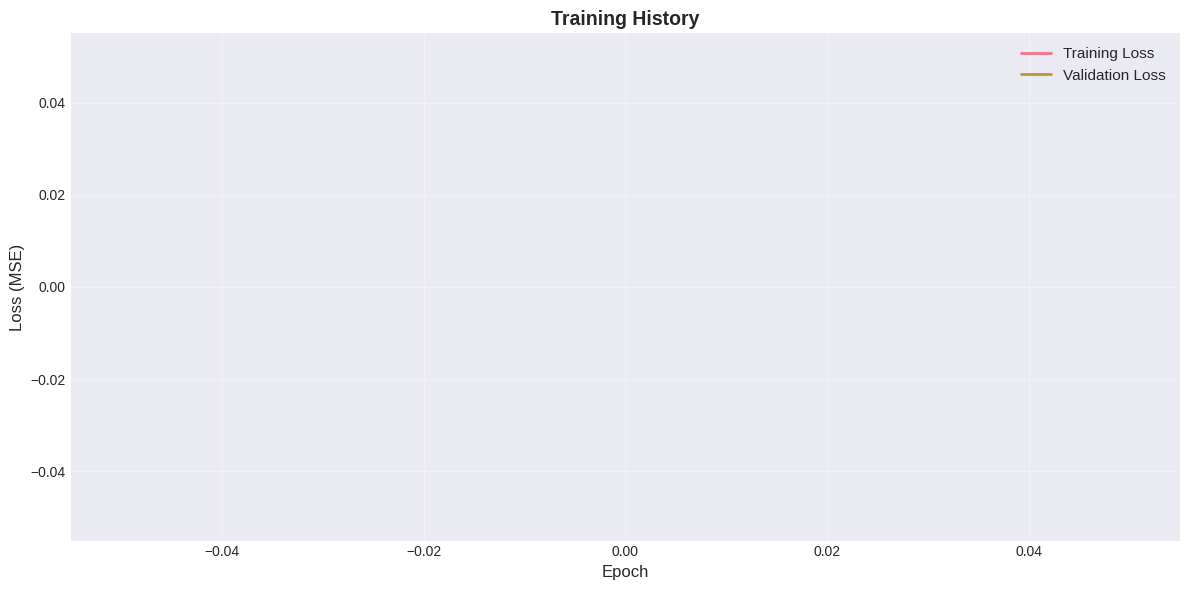

Training history plot saved to 'training_history.png'


In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

epochs_range = range(1, len(train_losses) + 1)
ax.plot(epochs_range, train_losses, label='Training Loss', linewidth=2)
ax.plot(epochs_range, val_losses, label='Validation Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print("Training history plot saved to 'training_history.png'")


In [25]:
model.eval()

all_predictions = []
all_actuals = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        predictions = model(x_batch).cpu().numpy().flatten()
        all_predictions.extend(predictions)
        all_actuals.extend(y_batch.numpy())

all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

test_loss = criterion(torch.FloatTensor(all_predictions), torch.FloatTensor(all_actuals)).item()
test_rmse = np.sqrt(test_loss)

pred_direction =(all_predictions > 0).astype(int)
actual_direction = (all_actuals > 0).astype(int)
directional_accuracy = (pred_direction == actual_direction).mean()


print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test Loss (MSE):        {test_loss:.6f}")
print(f"Test RMSE:              {test_rmse:.6f}")
print(f"Directional Accuracy:   {directional_accuracy:.2%}")
print(f"Random Baseline:        50.00%")
print(f"Improvement:            {(directional_accuracy - 0.5) * 100:+.2f}%")
print("="*60)

TEST SET EVALUATION
Test Loss (MSE):        1.005252
Test RMSE:              1.002622
Directional Accuracy:   52.08%
Random Baseline:        50.00%
Improvement:            +2.08%


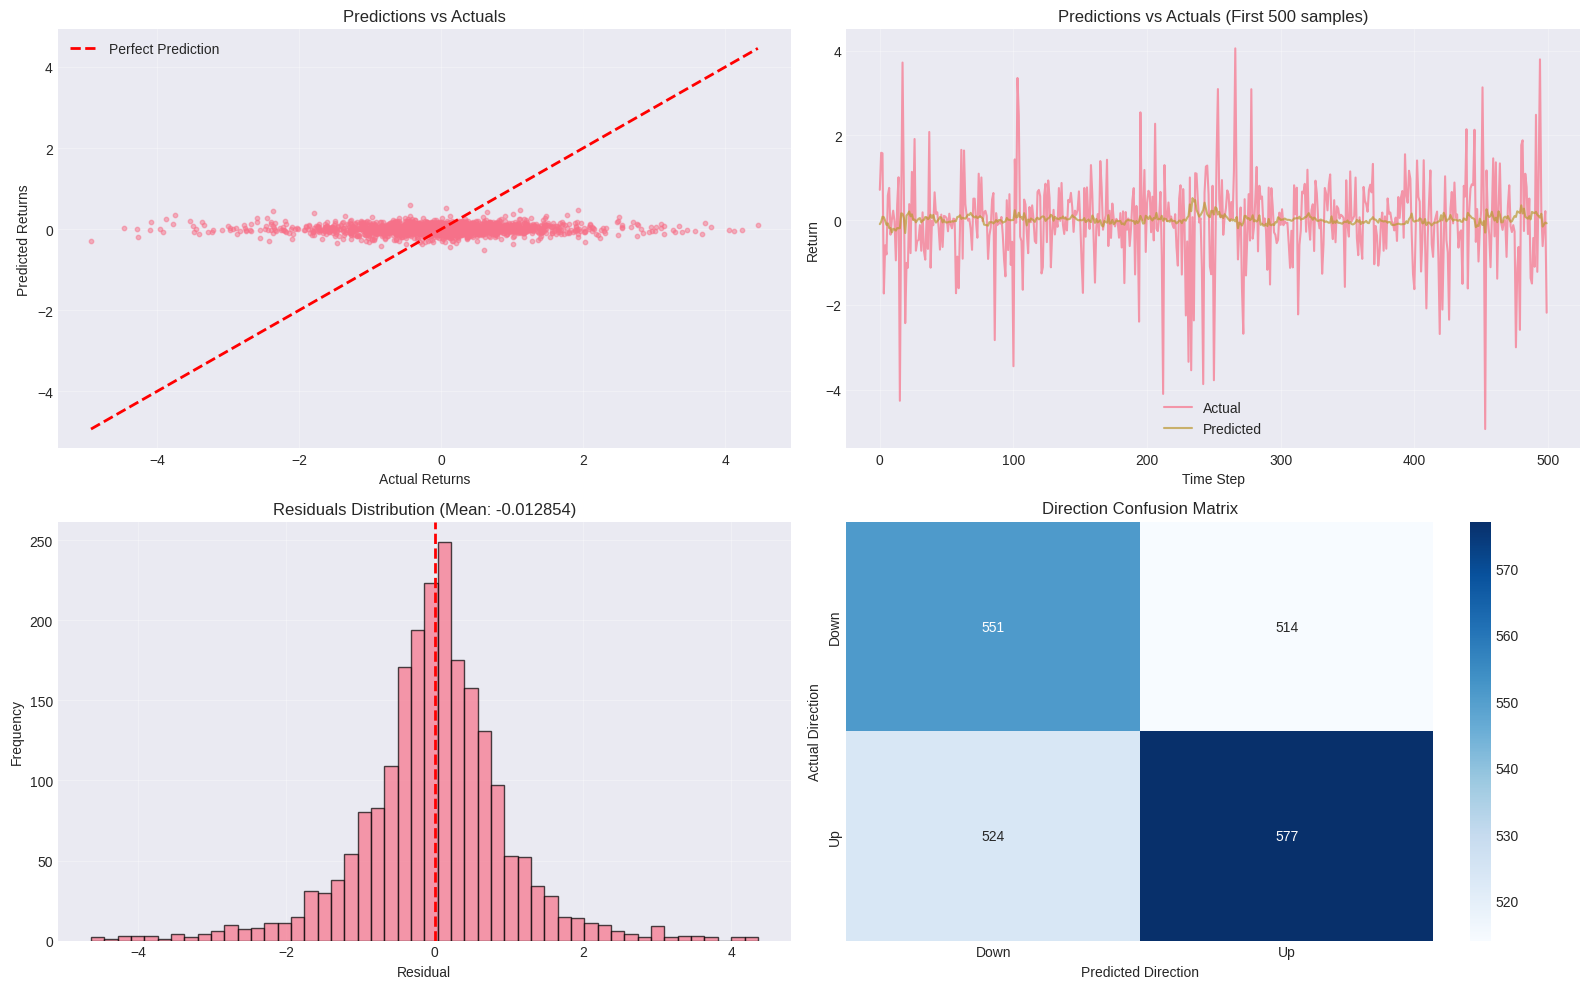

Predictions analysis plot saved to 'predictions_analysis.png'


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Predictions vs Actuals (scatter)
axes[0, 0].scatter(all_actuals, all_predictions, alpha=0.5, s=10)
axes[0, 0].plot([all_actuals.min(), all_actuals.max()], 
                [all_actuals.min(), all_actuals.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Returns')
axes[0, 0].set_ylabel('Predicted Returns')
axes[0, 0].set_title('Predictions vs Actuals')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Time series comparison
time_steps = np.arange(len(all_predictions))
axes[0, 1].plot(time_steps[:500], all_actuals[:500], label='Actual', alpha=0.7)
axes[0, 1].plot(time_steps[:500], all_predictions[:500], label='Predicted', alpha=0.7)
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Return')
axes[0, 1].set_title('Predictions vs Actuals (First 500 samples)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = all_actuals - all_predictions
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residuals Distribution (Mean: {residuals.mean():.6f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Confusion matrix for direction
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_direction, pred_direction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Direction')
axes[1, 1].set_ylabel('Actual Direction')
axes[1, 1].set_title('Direction Confusion Matrix')
axes[1, 1].set_xticklabels(['Down', 'Up'])
axes[1, 1].set_yticklabels(['Down', 'Up'])

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=150)
plt.show()

print("Predictions analysis plot saved to 'predictions_analysis.png'")

In [29]:
model.eval()

x_sample = torch.FloatTensor(x_test[:1000]).to(device)
x_sample.requires_grad = True

predictions = model(x_sample)
predictions.sum().backward()

feature_importance = x_sample.grad.abs().mean(dim=0).cpu().numpy()

importance_df = pd.DataFrame({
    'Feature': featured_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Top 10):")
display(importance_df.head(10))


Feature Importance (Top 10):


,Feature,Importance
2,BB_POSITION,0.079205
0,RSI_14,0.055962
13,LOWER_WICK_ATR,0.040504
7,ATR,0.040366
1,MACD_HIST,0.039070
6,PRICE_EMA21_DIST,0.035982
5,RET_15,0.033213
3,RET_1,0.033016
4,RET_5,0.032007
9,VOL,0.031533


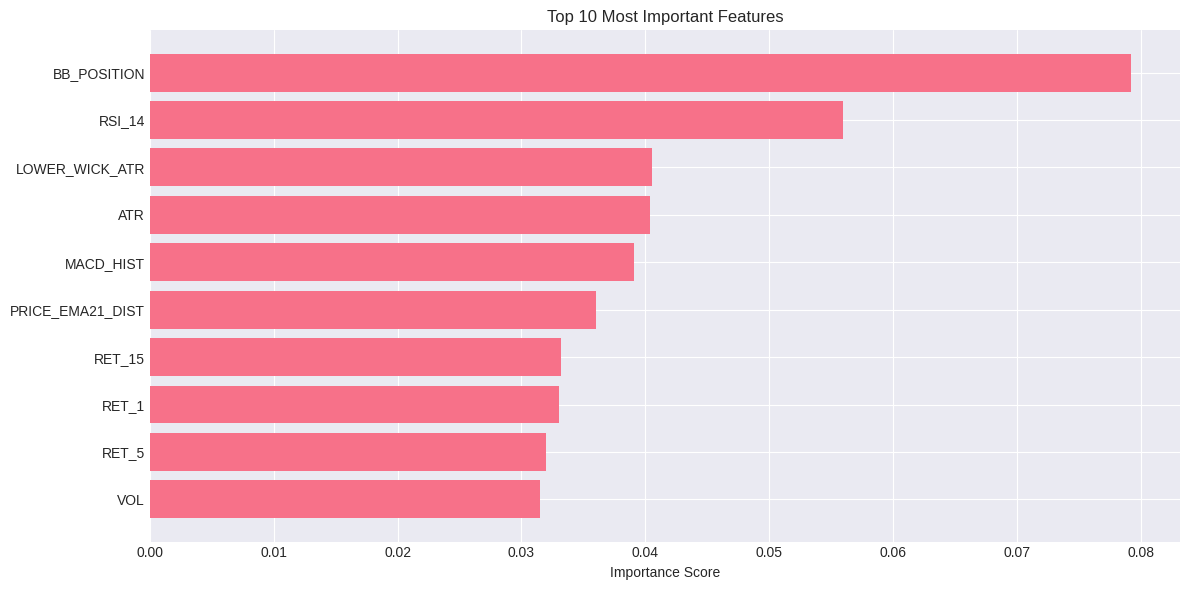

Feature importance plot saved to 'feature_importance.png'


In [28]:

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance Score')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

print("Feature importance plot saved to 'feature_importance.png'")

In [30]:
results = {
    'test_loss': test_loss,
    'test_rmse': test_rmse,
    'directional_accuracy': directional_accuracy,
    'feature_cols': featured_cols,
    'model_config': {
        'input_size': input_size,
        'hidden_sizes': HIDDEN_SIZES,
        'dropout': DROPOUT
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'epochs': len(train_losses),
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY
    }
}

# Save to file
import json
with open('training_results.json', 'w') as f:
    # Convert numpy values to Python native types
    results_serializable = {
        'test_loss': float(results['test_loss']),
        'test_rmse': float(results['test_rmse']),
        'directional_accuracy': float(results['directional_accuracy']),
        'feature_cols': results['feature_cols'],
        'model_config': results['model_config'],
        'training_config': results['training_config']
    }
    json.dump(results_serializable, f, indent=2)

print("✓ Model saved to: best_model.pth")
print("✓ Results saved to: training_results.json")
print("\nTraining pipeline complete! 🎉")

✓ Model saved to: best_model.pth
✓ Results saved to: training_results.json

Training pipeline complete! 🎉


In [31]:
featured_cols

['RSI_14',
 'MACD_HIST',
 'BB_POSITION',
 'RET_1',
 'RET_5',
 'RET_15',
 'PRICE_EMA21_DIST',
 'ATR',
 'RET_STD',
 'VOL',
 'VWAP_DIST',
 'BODY_ATR',
 'UPPER_WICK_ATR',
 'LOWER_WICK_ATR']